In [77]:
# Import required libraries
import pandas as pd
import numpy as np
from scipy.stats import norm
import ipywidgets as widgets

from ipywidgets import interact
import matplotlib.pyplot as plt
from tabulate import tabulate # conda install tabulate

import plotly.graph_objects as go
import plotly.express as px
import plotly as py
from plotly.subplots import make_subplots

# Black Scholes equation and pricing formula
The Black–Scholes PDE and formula for the price of an option $V(S,t)$ is given by
\begin{equation}
\frac{\partial V}{\partial t}
+ \frac 1{2}{\sigma^2 S^2} \frac{\partial^2 V}{\partial S^2}
+ r S \frac{\partial V}{\partial S} - rV = 0.
\label{eq:1}
\end{equation}
$$C\left(S,t\right)  =Se^{-D(T-t)}N(d_{1})-Ee^{-r(T-t)}N(d_{2})$$
and
$$ P\left(S,t\right)  =-Se^{-D(T-t)}N(-d_{1})+Ee^{-r(T-t)}N(-d_{2})$$

where

$$d_{1,2}=\frac{\log(S/E)+(r-D\pm\frac{1}{2}\sigma^{2})(T-t)}{\sigma\sqrt{T-t}%
}\;\text{with}$$

$$d_{2}=d_{1}-\sigma\sqrt{T-t}$$


$$N(x)=\frac{1}{\sqrt{2\pi}}\int_{-\infty}^{x}e^{-\frac{1}{2}\phi^{2}}d\phi$$ is the cumulative distribution function for the normal distribution.

## Greeks
Assuming no dividend!

### Delta $\Delta$
$\frac {\partial V}{\partial S}$ Sensitivity of Value to changes in price


| Call | Put |
| --- | --- |
| $$ N(d_1) $$ | $$ -N(-d_1) $$ |


### Gamma $\Gamma$
$\frac {\partial ^{2}V}{\partial S^{2}}$ Sensitivity of Delta to changes in price

| Call | Put |
| --- | --- |
| $$\frac{N'(d_1)}{S\sigma\sqrt{t}}$$ | $$\frac{N'(d_1)}{S\sigma\sqrt{t}}$$ |

### Theta $\Theta$
$\frac {\partial V}{\partial t}$ Sensitivity of Value to changes in time

| Call | Put |
| --- | --- |
| $$-\frac{SN'(d_1)\sigma}{2\sqrt{t}}-rKe^{-rt}N(d_2)$$ | $$-\frac{SN'(d_1)\sigma}{2\sqrt{t}}+rKe^{-rt}N(-d_2)$$ |


### Vega $v$
$\frac {\partial V}{\partial \sigma}$ Sensitivity of Value to changes in volatility

| Call | Put |
| --- | --- |
| $$SN'(d_1)\sqrt{t} $$ | $$SN'(d_1)\sqrt{t} $$ |

### Rho $\rho$
$ \frac {\partial V}{\partial r}$  Sensitivity of Value to changes in risk-free


| Call | Put |
| --- | --- |
| $$Kte^{-rt}N(d_2)$$ | $$-Kte^{-rt}N(-d_2)$$ |


In [6]:
class EuroBlackScholes:
    
    """
    This is a class for Options contract for pricing European options on stocks without dividends.
    
    Attributes: 
        spot          : int or float
        strike        : int or float 
        rate          : float
        dte           : int or float [days to expiration in number of years]
        volatility    : float
    """    
    
    def __init__(self, spot, strike, rate, tte, volatility):
        
        # Spot Price
        self.spot = spot
        
        # Option Strike
        self.strike = strike
        
        # Interest Rate
        self.rate = rate
        
        # Days To Expiration
        self.tte = tte
        
        # Vol
        self.volatility = volatility
        
        # Utility 
        self._a_ = self.volatility * self.tte**0.5
       
        if self.strike == 0:
            raise ZeroDivisionError('The strike price cannot be zero')
        else:
            self._d1_ = (np.log(self.spot / self.strike) + \
                     (self.rate + (self.volatility**2) / 2) * self.tte) / self._a_
        
        self._d2_ = self._d1_ - self._a_
        
        self._b_ = np.exp(-(self.rate * self.tte))
        
        
        # The __dict__ attribute
        '''
        Contains all the attributes defined for the object itself. It maps the attribute name to its value.
        '''
        for i in ['callPrice', 'putPrice', 'callDelta', 'putDelta', 'callTheta', 'putTheta', \
                  'callRho', 'putRho', 'vega', 'gamma']:
            self.__dict__[i] = None
        
        [self.callPrice, self.putPrice] = self._price()
        [self.callDelta, self.putDelta] = self._delta()
        [self.callTheta, self.putTheta] = self._theta()
        [self.callRho, self.putRho] = self._rho()
        self.vega = self._vega()
        self.gamma = self._gamma()
        
    
    # Option Price
    def _price(self):
        '''Returns the option price: [Call price, Put price]'''

        if self.volatility == 0 or self.tte == 0:
            call = np.maximum(0.0, self.spot - self.strike)
            put = np.maximum(0.0, self.strike - self.spot)
        else:
            call = self.spot * norm.cdf(self._d1_) - self.strike * e**(-self.rate * \
                                                                       self.tte) * norm.cdf(self._d2_)

            put = self.strike * np.exp(-self.rate * self.tte) * norm.cdf(-self._d2_) - \
                                                                        self.spot * norm.cdf(-self._d1_)
        return [call, put]

    # Option Delta
    def _delta(self):
        '''Returns the option delta: [Call delta, Put delta]'''

        if self.volatility == 0 or self.tte == 0:
            call = 1.0 if self.spot > self.strike else 0.0
            put = -1.0 if self.spot < self.strike else 0.0
        else:
            call = norm.cdf(self._d1_)
            put = -norm.cdf(-self._d1_)
        return [call, put]

    # Option Gamma
    def _gamma(self):
        '''Returns the option gamma'''
        return norm.pdf(self._d1_) / (self.spot * self._a_)

    # Option Vega
    def _vega(self):
        '''Returns the option vega'''
        if self.volatility == 0 or self.tte == 0:
            return 0.0
        else:
            return self.spot * norm.pdf(self._d1_) * self.tte**0.5 / 100

    # Option Theta
    def _theta(self):
        '''Returns the option theta: [Call theta, Put theta]'''
        call = -self.spot * norm.pdf(self._d1_) * self.volatility / (2 * self.tte**0.5) - self.rate * self.strike * self._b_ * norm.cdf(self._d2_)

        put = -self.spot * norm.pdf(self._d1_) * self.volatility / (2 * self.tte**0.5) + self.rate * self.strike * self._b_ * norm.cdf(-self._d2_)
        return [call / 365, put / 365]

    # Option Rho
    def _rho(self):
        '''Returns the option rho: [Call rho, Put rho]'''
        call = self.strike * self.tte * self._b_ * norm.cdf(self._d2_) / 100
        put = -self.strike * self.tte * self._b_ * norm.cdf(-self._d2_) / 100

        return [call, put]
    

In [16]:
# Initialize option
option = BS(100,100,0.05,1,0.2)

header = ['Call Price', 'Delta', 'Gamma', 'Theta', 'Vega', 'Rho']
table = [[option.callPrice, option.callDelta, option.gamma, option.callTheta, option.vega, option.callRho]]

print(tabulate(table,header))
header = ['Put Price', 'Delta', 'Gamma', 'Theta', 'Vega', 'Rho']
table = [[option.putPrice, option.putDelta, option.gamma, option.putTheta, option.vega, option.putRho]]
print('\n')
print(tabulate(table,header))

  Call Price     Delta     Gamma       Theta     Vega       Rho
------------  --------  --------  ----------  -------  --------
     10.4506  0.636831  0.018762  -0.0175727  0.37524  0.532325


  Put Price      Delta     Gamma        Theta     Vega        Rho
-----------  ---------  --------  -----------  -------  ---------
    5.57353  -0.363169  0.018762  -0.00454214  0.37524  -0.418905


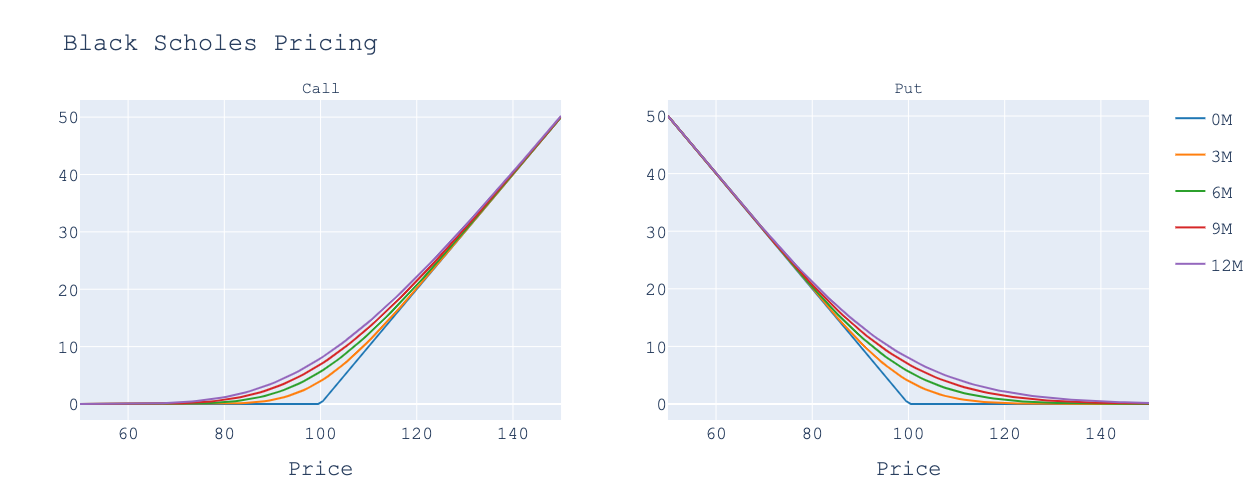

In [78]:
fig = make_subplots(rows=1, cols=2, subplot_titles=("Call", "Put"))

cols = py.colors.DEFAULT_PLOTLY_COLORS

x = linspace(50,150,100)
d = {'0M':1e-50, '3M': 0.25, '6M': 0.5, '9M': 0.75, '12M': 1.0}

for i, (k,v) in enumerate(d.items()):
    axes[0].plot(x, BS(x,100,0.0,v,0.2).callPrice, label=k)
    fig.add_trace(go.Scatter(x=x, y=BS(x,100,0.0,v,0.2).callPrice, name=k, legendgroup=f'group{k}', line=dict(color=cols[i])),
              row=1, col=1)
    axes[1].plot(x, BS(x,100,0.0,v,0.2).putPrice, label=k)
    fig.add_trace(go.Scatter(x=x, y=BS(x,100,0.0,v,0.2).putPrice, name=k, legendgroup=f'group{k}', line=dict(color=cols[i]), showlegend=False),
              row=1, col=2)

fig.update_layout(
    title="Black Scholes Pricing",
    width=1200,
    height=500,
    font=dict(
        family="Courier New",
        size=18
    )
)

fig.update_xaxes(title_text="Price", row=1, col=1)
fig.update_xaxes(title_text="Price", row=1, col=2)

fig.show()

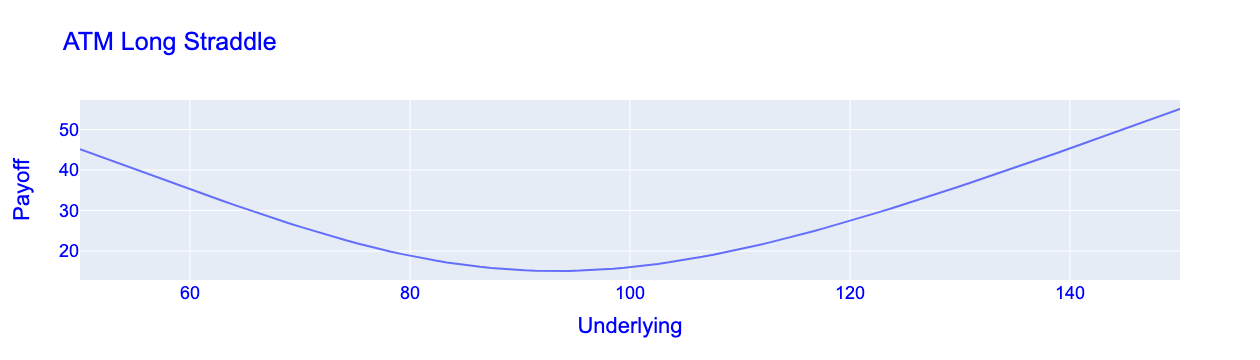

In [76]:
# Plot straddle price 
fig = go.Figure()
fig.add_trace(go.Line(x=x, y=(BS(x,100,0.05,1,0.2).callPrice + BS(x,100,0.05,1,0.2).putPrice)))
fig.update_layout(
    title="ATM Long Straddle",
    xaxis_title="Underlying",
    yaxis_title="Payoff",
    font=dict(
        family="Arial",
        size=18,
        color="Blue"
    )
)
fig.show()

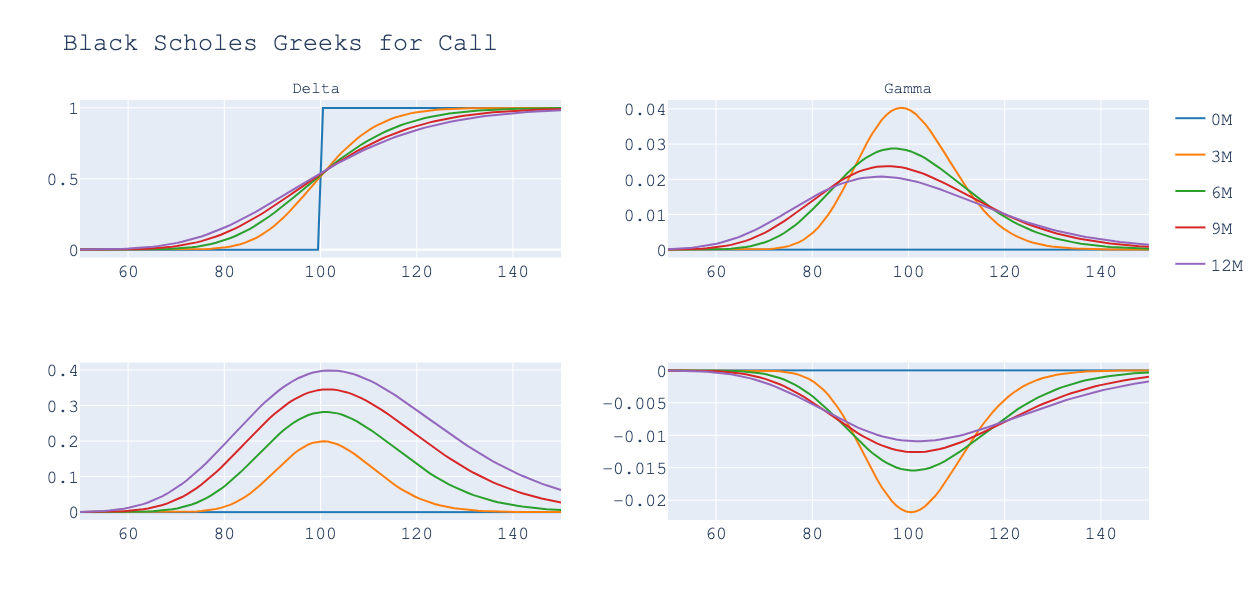

In [85]:
# # Plot graph iteratively
# fig, ax = plt.subplots(2,2, figsize=(20,10))
fig = make_subplots(rows=2, cols=2, subplot_titles=("Delta ", "Gamma"))
for i, (k,v) in enumerate(d.items()):
    fig.add_trace(go.Scatter(x=x, y=BS(x,100,0.0,v,0.2).callDelta, name=k, legendgroup=f'group{k}', line=dict(color=cols[i])), row=1, col=1)
    fig.add_trace(go.Scatter(x=x, y=BS(x,100,0.0,v,0.2).gamma, name=k, legendgroup=f'group{k}', line=dict(color=cols[i]), showlegend=False), row=1, col=2)
    fig.add_trace(go.Scatter(x=x, y=BS(x,100,0.0,v,0.2).vega, name=k, legendgroup=f'group{k}', line=dict(color=cols[i]), showlegend=False), row=2, col=1)
    fig.add_trace(go.Scatter(x=x, y=BS(x,100,0.0,v,0.2).callTheta, name=k, legendgroup=f'group{k}', line=dict(color=cols[i]), showlegend=False), row=2, col=2)

    
fig.update_layout(
    title="Black Scholes Greeks for Call",
    width=1200,
    height=600,
    font=dict(
        family="Courier New",
        size=18
    )
)

fig.show()